# Évaluation des prévisions d'ensemble à travers une analyse statistique sur des données de température et de vent (ARPEGE) 

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm, gamma
from pathlib import Path

%matplotlib inline

np.set_printoptions(threshold=np.inf)

## Base de l'algorithme

### Variables

Nous allons tout d'abord définir les variables fixes: nombre de jours sur lesquels on fait l'analyse et nombre de membres du modèle dans chaque cas. Tout le long de l'exercice, les élements relatifs à la température seront marqués avec un T et au vent, avec un V.

In [72]:
#############
# Variables #
#############

# Nombre de membres
kT = 34 
kV = 35
kVa = 35
# Nombre de jours testés
NT = 12600
NV = 33090
NVa = 12600
# Variables vent
delta = 7
epsilon = 0.01

### Fonctions

On va aussi définir les fonctions dont nous allons avoir besoin pour faire nos calculs dans un premier temps.

#### Probabilités

Commençons par la fonction qui nous sort la liste de probabilités de l'évenement E correspondante à chaque jour:

In [73]:
def prob(cond_prev, k, N):
    if k == 1:
        prob = cond_prev.astype(int)
    else:
        prob = np.sum(cond_prev, axis=1)/k
    return prob

#### Fréquence Np

On a une fonction qui nous sort la liste des probabilités prévues (issue de l'autre fonction) avec ses correspondentes fréquences de prévision:

In [74]:
def Np(prob):
    # np.unique nous sort la liste de valeurs (vals) qu'on regarde 
    # avec ses fréquences correspondentes (counts) 
    vals, counts = np.unique(prob, return_counts=True)
    return np.vstack([vals, counts]).T

#### p'(p)

La fonction suivante calcule la fréquence réelle de l'événement lors de la prévision de chaque catégorie de probabilité p:

In [75]:
def pPrime(cond_obs, prob, Np):
    cond_obs= np.asarray(cond_obs, dtype=int)
    prob = np.asarray(prob)
    Np = np.asarray(Np)
    # On prend le vecteur de probas
    pVals = Np[:,0]
    # On créé une matrice booléenne qui indique les jours qui ont une proba p
        # Il s'agit de comparer toutes les probas avec les resultats de TOUS les jours
        # mask[j,i] = True sii prob[j] == pVals[i]
    mask = prob[:, None] == pVals[None,:] 
    # Pour chaque p, on additionne les cond_obs des jours où prob(jour) = p
        # mask et cond_obs agissent comme des indicatrices de p et epsilon 
        # en les mutipliant on obtient la double condition: evenement produit et p prévu
    sums = mask.T @ cond_obs 
    # On divise entre les fréquences Np
    p_prime = sums/Np[:,1]
    return np.column_stack([pVals, p_prime])

#### Hit Rate (H)

La fonction H calcule, pour chaque catégorie de probabilité et tous les cas où E s'est produit, la fréquence avec laquelle la probabilité prévue a été supérieure ou égale à p:

In [76]:
def H(cond_obs, prob, k):
    cond_obs = np.asarray(cond_obs, dtype=int)
    prob = np.asarray(prob)
    
    pCats = np.arange(k+1)/k
    N1 = cond_obs.sum()
    
    mask = prob[:, None] >= pCats[None, :]
    Hvals = (mask * cond_obs[:, None]).sum(axis=0) / N1
    return Hvals

#### False Alarm (F)

La fonction F calcule, pour chaque catégorie de probabilité et tous les cas où E ne s'est produit, la fréquence avec laquelle la probabilité prévue a été supérieure ou égale à p:

In [77]:
def F(cond_obs, prob, k):
    cond_obs = np.asarray(cond_obs, dtype=int)
    prob = np.asarray(prob)
    
    indC = 1 - cond_obs
    pCats = np.arange(k+1)/k
    N0 = indC.sum()
    
    mask = prob[:, None] >= pCats[None, :]
    Fvals = (mask * indC[:, None]).sum(axis=0) / N0
    return Fvals

#### Probabilité Climatologique

La probabilité climatologique est la moyenne de jours où l'évenement s'es produit par rapport à la totalité de jours qu'on évalue. 

In [78]:
def pC(cond_obs, N):
    return np.mean(cond_obs)

#### Score de Brier

Le score de Brier se décompose en plusieurs parties qui mesurent: la fiabilité, la résolution et l'incertitude. Voilà le code pour chacune de ces formules.

In [79]:
# Fiabilité
def BrierFiab(Np, pPrime, N): 
    Np = np.asarray(Np)
    pPrime = np.asarray(pPrime)
    return np.sum(Np[:,1] * (Np[:,0] - pPrime[:,1])**2) / N

# Résolution
def BrierRes(Np, pPrime, N, pc):
    Np = np.asarray(Np)
    pPrime = np.asarray(pPrime)
    return np.sum(Np[:,1] * (pPrime[:,1] - pc)**2) / N

# Score de Brier
def Brier(Np, pPrime, N, pc):
    return BrierFiab(Np, pPrime, N) - BrierRes(Np, pPrime, N, pc) + pc * (1-pc)

# Brier Skill Score
def BSS(Np, pPrime, N, pc):
    bf = BrierFiab(Np, pPrime, N)
    br = BrierRes(Np, pPrime, N, pc)
    bi = pc * (1-pc)
    return (br - bf)/bi

## 1ère Analyse

### Main

Maintenant, on va mette le les choses en place pour pouvoir utiliser toutes ces fonctions. La première étape est d'importer les deux bases de données avec le module pandas. Après, on les classe dans les vecteurs d'obervation et de prévision. 

In [80]:
# DONNÉES
#########

# Carpeta donde está este archivo .py
BASE_DIR = Path.cwd().resolve().parent.parent

# Rutas a los ficheros
ruta_T  = BASE_DIR / "These_MF" / "Data" / "donnees_test_temperature.txt"
ruta_V  = BASE_DIR / "These_MF" / "Data" / "donnees_test_vent.txt"
ruta_Va = BASE_DIR / "These_MF" / "Data" / "donnees_test_vent_analyse.txt"

dfT = pd.read_csv(ruta_T, sep=r'\s+', header=None)
dfV = pd.read_csv(ruta_V, sep=r'\s+', header=None)
dfVa = pd.read_csv(ruta_Va, sep=r'\s+', header=None)

# Temperature
obsT = dfT.iloc[:, -1] 
prevT = dfT.iloc[:, 0:kT].to_numpy()

# Vent observation
obsV = dfV.iloc[:, -1] 
prevV = dfV.iloc[:, 0:kV].to_numpy()

# Vent analyse
obsVa = dfVa.iloc[:, -1]
prevVa = dfVa.iloc[:, 0:kVa].to_numpy()

Avec cela on peut définir la condition binaire (dans ce cas là on a pris le dépassement d'un seuil: la médiane) et établir qulles sont les predictions où l'évenement E est respecté. Voici la fonction mainExec qui réalise le reste de l'analyse statistique.

In [81]:
" En voyant le nombre de fois où nous allons repeter les mêmes  "
" lignes de code, on va faire des fonctions principales pour    "
" le main afin de mieux ranger notre code                       "

def mainExec(obs, prev, k, N, percentile):
    # ÉLÉMENTS DE CALCUL
    ####################
    # Condition à établir
    cond = np.percentile(obs, percentile)
    # Événement théorique
    Etheo = prev > cond
    # Événement observé
    Eobs = obs > cond
    # Vecteur de probabilités par jour
    prob_vecteur = prob(Etheo, k, N)
    # Matrice de fréquences de probabilités
    Np_matrice = Np(prob_vecteur)
    Np_matrice = np.array(Np_matrice)
    # Matrices de fréquences réelles (p'(p))
    pPrime_matrice = pPrime(Eobs, prob_vecteur, Np_matrice)
    # Probabilité climatologique
    pc = pC(Eobs, N)
    # H et F
    hit_rate = H(Eobs, prob_vecteur, k)
    false_alarm = F(Eobs, prob_vecteur, k)

    # SCORES
    ########
    # brierScore = Brier(Np_matrice, pPrime_matrice, N, pc)
    # brierSkill = BSS(Np_matrice, pPrime, N, pc)
    
    return cond, Etheo, Eobs, Np_matrice, pPrime_matrice, pc, hit_rate, false_alarm  

Maintenant on execute:

In [82]:
condT50, EtheoT50, EobsT50, NpT50, pPrimeT50, pcT50, HT50, FT50 = mainExec(obsT, prevT, kT, NT, 50)
condT90, EtheoT90, EobsT90, NpT90, pPrimeT90, pcT90, HT90, FT90 = mainExec(obsT, prevT, kT, NT, 90)

condV50, EtheoV50, EobsV50, NpV50, pPrimeV50, pcV50, HV50, FV50 = mainExec(obsV, prevV, kV, NV, 50)
condV90, EtheoV90, EobsV90, NpV90, pPrimeV90, pcV90, HV90, FV90 = mainExec(obsV, prevV, kV, NV, 90)

condVa50, EtheoVa50, EobsVa50, NpVa50, pPrimeVa50, pcVa50, HVa50, FVa50 = mainExec(obsVa, prevVa, kV, NV, 50)
condVa90, EtheoVa90, EobsVa90, NpVa90, pPrimeVa90, pcVa90, HVa90, FVa90 = mainExec(obsVa, prevVa, kV, NV, 90)

Avec cela nous avons tous nos éléments de calcul. Maintenant nous pouvons tracer les graphiques qui vont nous permettre d'évaluer si notre modèle est fiable et/ou a une bonne résolution.

### Diagrammes

Avec le diagramme de fiabilité nous sommes capables de voir à quel point le modèle avec lequel on a réalisé nos prévisions est fiable sur le point analysé. On trace p'(p) en fonction de p et plus la courbe résultante est près de l'identité, plus le modèle est fiable. Pour les tracer on va définir des dictionnaires et, à la fin, préciser les fonctions qui tracent les graphiques qu'on veut voir.

In [83]:
# Diagramme de fiabilité
########################

pc = [pcT50, pcT90, pcV50, pcV90, pcVa50, pcVa90]

dict_fiab = {"Température_50": pPrimeT50, "Température_90": pPrimeT90,
            "Vent_obs_50": pPrimeV50, "Vent_obs_90": pPrimeV90,
            "Vent_analyse_50": pPrimeVa50, "Vent_analyse_90": pPrimeVa90}
# Diagramme d'acuité
####################

dict_acuite = {"Température_50": NpT50, "Température_90": NpT90,
                "Vent_obs_50": NpV50, "Vent_obs_90": NpV90,
                "Vent_analyse_50": NpVa50, "Vent_analyse_90": NpVa50}

# Courbe de ROC
###############

FHT50 = np.vstack((FT50, HT50)).T
FHT90 = np.vstack((FT90, HT90)).T
FHV50 = np.vstack((FV50, HV50)).T
FHV90 = np.vstack((FV90, HV90)).T
FHVa50 = np.vstack((FVa50, HVa50)).T
FHVa90 = np.vstack((FVa90, HVa90)).T

dict_ROC = {"Température_50": FHT50, "Température_90": FHT90,
                "Vent_obs_50": FHV50, "Vent_obs_90": FHV90,
                "Vent_analyse_50": FHVa50, "Vent_analyse_90": FHVa90}

Fiab=True
Acuite=True
ROC=True


Voici les fonctions qui tracent les graphiques accompagnées de la fonction qui va venir les exécuter.

In [84]:
def graphic_plt_id (dictionnaire, nPer, nVar, pc, PC, titre, titre_variable, xlabel, ylabel, SCT):
    DEUX=False
    nFig, axs = plt.subplots(nPer, nVar, figsize=(20,14))
    axs = np.atleast_2d(axs)
    
    nFig.suptitle(titre, fontsize=16)
    titres = list(dictionnaire.keys())
    matrices = list(dictionnaire.values())

    for i, mat in enumerate(matrices):
        row = (i) % nPer
        col = int(i/nPer)

        vect0 = mat[:,0]
        vect1 = mat[:,1]
        
        if mat.shape[1] > 2:
            vect2 = mat[:,2]
            vect3 = mat[:,3]
        # Cela voudrait dire qu'on veut plus d'une courbe dans chaque graphique
        axs[row,col].plot(vect0, vect0, label="id", color='blue')
        if SCT == True:
            axs[row,col].scatter(vect0, vect1, label=titre_variable, color='red')
            if mat.shape[1] > 2:
                axs[row,col].scatter(vect2, vect3, label="avant", color='gray')
        else:
            axs[row,col].plot(vect0, vect1, label=titre_variable, color='red')
            if mat.shape[1] > 2:
                axs[row,col].plot(vect2, vect3, label="avant", color='gray')
        if PC == True:
            axs[row,col].plot(vect0, np.full((len(mat),), pc[i]), label="pC", color='green')
        axs[row,col].set_title(titres[i])
        axs[row,col].set_xlabel(xlabel)
        axs[row,col].set_ylabel(ylabel)
        axs[row,col].legend() 
        axs[row,col].grid(True)

    plt.tight_layout()
    plt.show()

In [85]:
def graphic_bar (dictionnaire, nPer, nVar, titre, titre_variable, xlabel, ylabel):
    nFig, axs = plt.subplots(nPer, nVar, figsize=(20,14))
    axs = np.atleast_2d(axs)

    nFig.suptitle(titre, fontsize=16)
    titres = list(dictionnaire.keys())
    matrices = list(dictionnaire.values())

    for i, (mat) in enumerate(matrices):
        row = (i) % nPer
        col = int(i/nPer)

        vect1 = mat[:,0]
        vect2 = mat[:,1]

        axs[row,col].bar(vect1, vect2, label=titre_variable)
        axs[row,col].set_title(titres[i])
        axs[row,col].set_xlabel(xlabel)
        axs[row,col].set_ylabel(ylabel)
        axs[row,col].legend() 
        axs[row,col].grid(True)

    plt.tight_layout()
    plt.show()


In [86]:
def graphsExec(Fiab, Acuite, ROC, dict_fiab, pc, dict_acuite, dict_ROC, per, nVar):
    
    # Titres Fiabilité
    titre_fiab = "Diagramme de fiabilité: 50 et 90"
    titre_variable_fiab = "pPrime(p)"
    xlabel_fiab = "probabilités (%)"
    ylabel_fiab = "fréquence réelle (%)"
    
    # Titres Acuité
    titre_acuite = "Diagramme d'acuité: 50 et 90"
    titre_variable_acuite= ""
    xlabel_acuite = "probabilités (%)"
    ylabel_acuite = "fréquence (%)"
    
    # Titres ROC 
    titre_ROC = "Courbe ROC: 50 et 90"
    titre_variable_ROC = "H(F)"
    xlabel_ROC = "False alarm"
    ylabel_ROC = "Hit rate"

    
    if Fiab==True:
        PC=True
        SCT=False
        graphic_plt_id(dict_fiab, len(per), nVar, pc, PC, titre_fiab, titre_variable_fiab, xlabel_fiab, ylabel_fiab, SCT)
        
    if Acuite==True:
        graphic_bar(dict_acuite, len(per), nVar, titre_acuite, titre_variable_acuite, xlabel_acuite, ylabel_acuite)
        
    if ROC==True:
        PC=False
        SCT=True
        graphic_plt_id(dict_ROC, len(per), nVar, pc, PC, titre_ROC, titre_variable_ROC, xlabel_ROC, ylabel_ROC, SCT)

On execute toutes ces fonctions et on obtient les 3 diagrammes qu'on voulait:

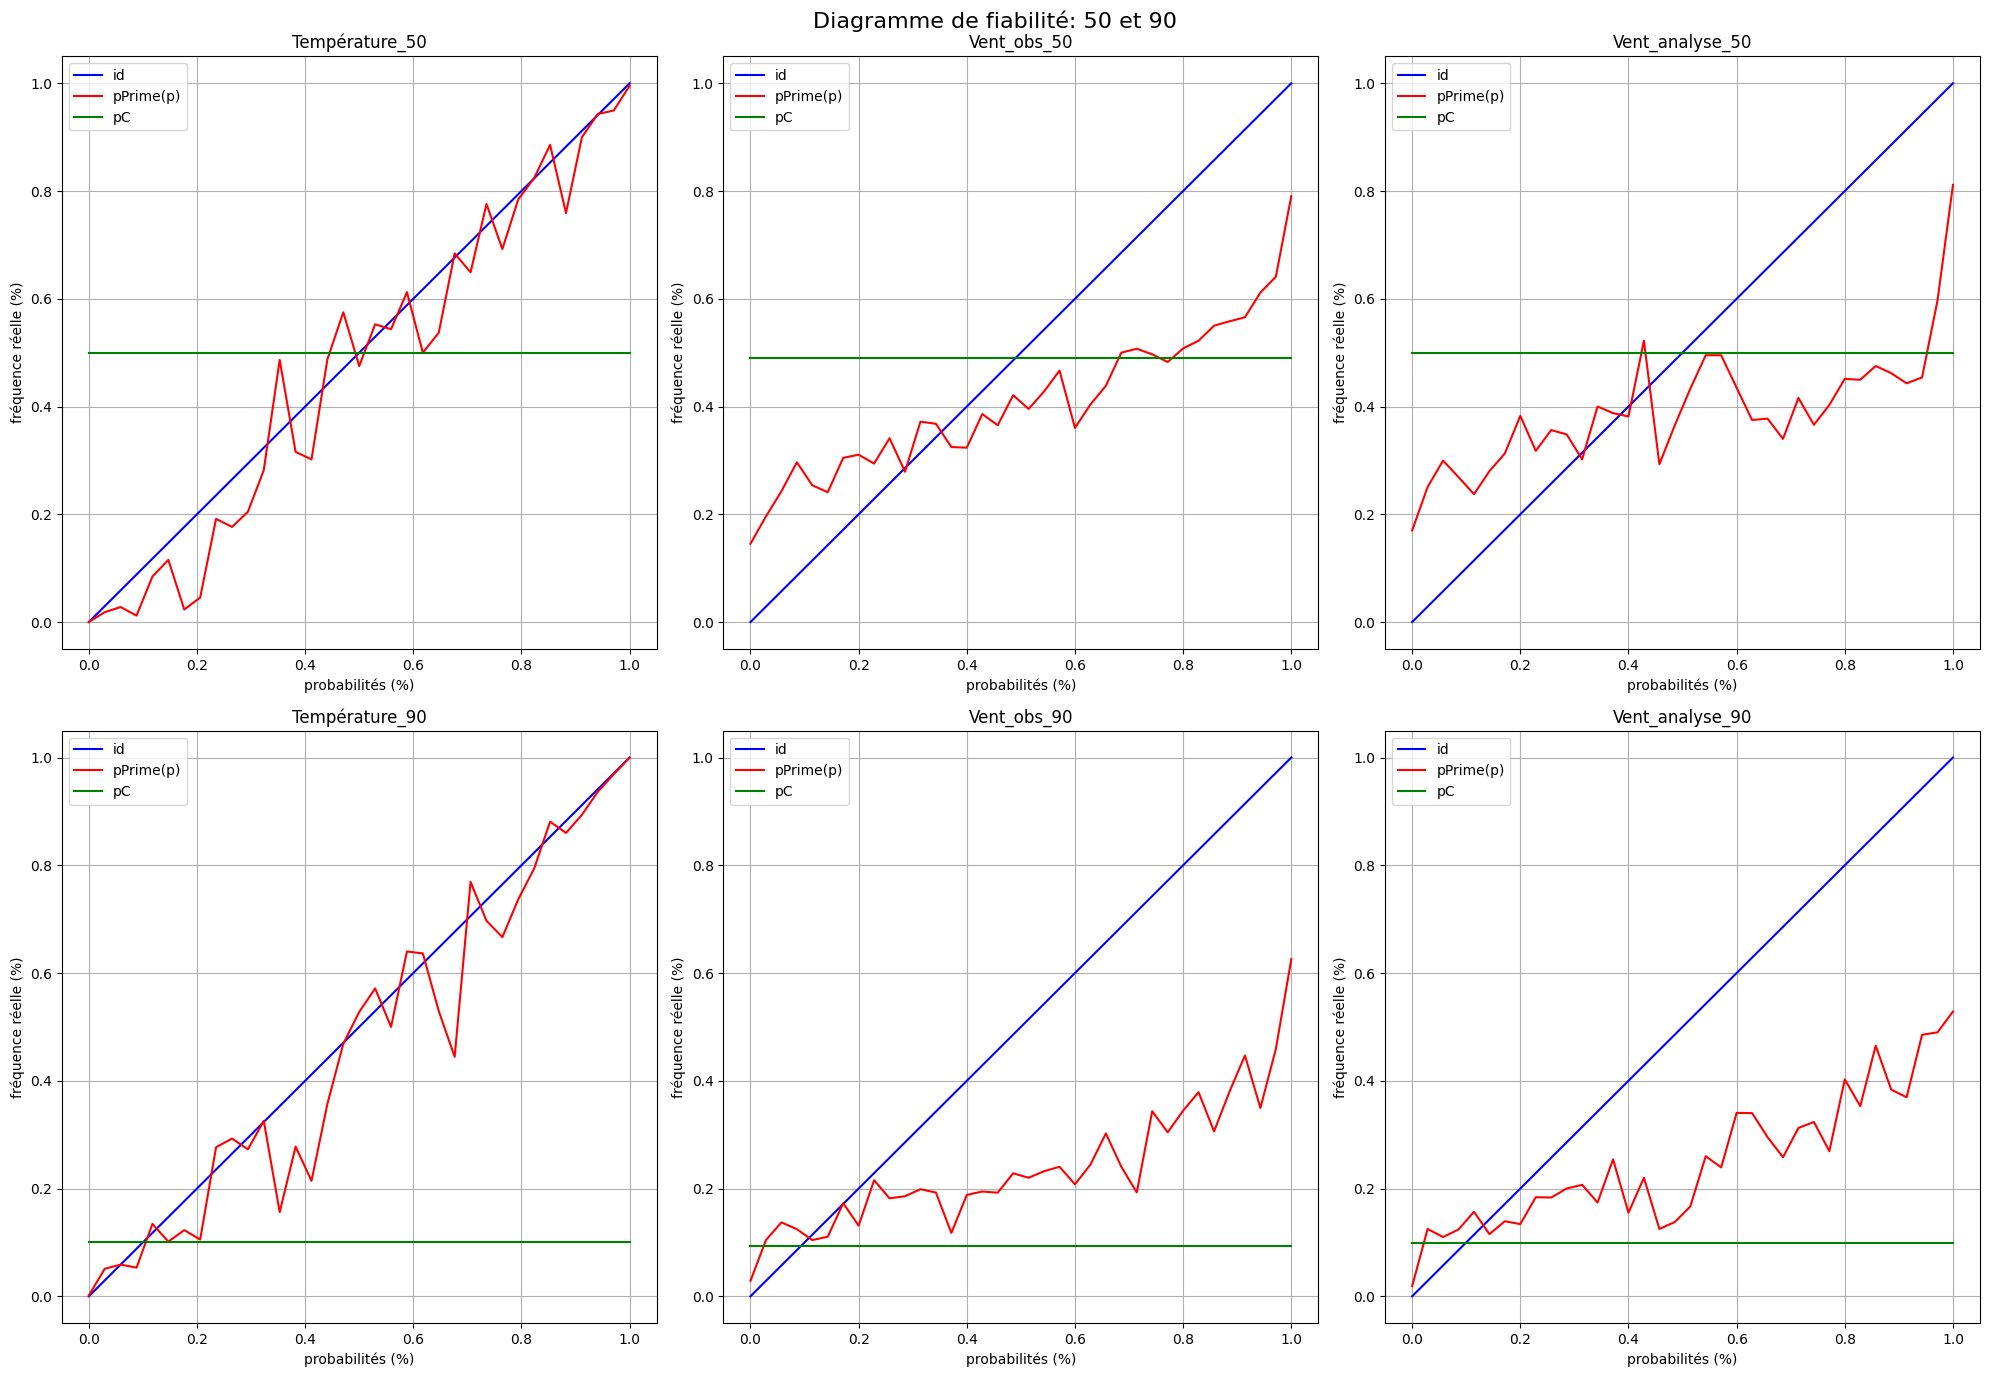

/var/folders/xf/srzrz9sd5xgb879vnxs7l8sm0000gn/T/ipykernel_17919/3152767949.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row,col].legend()


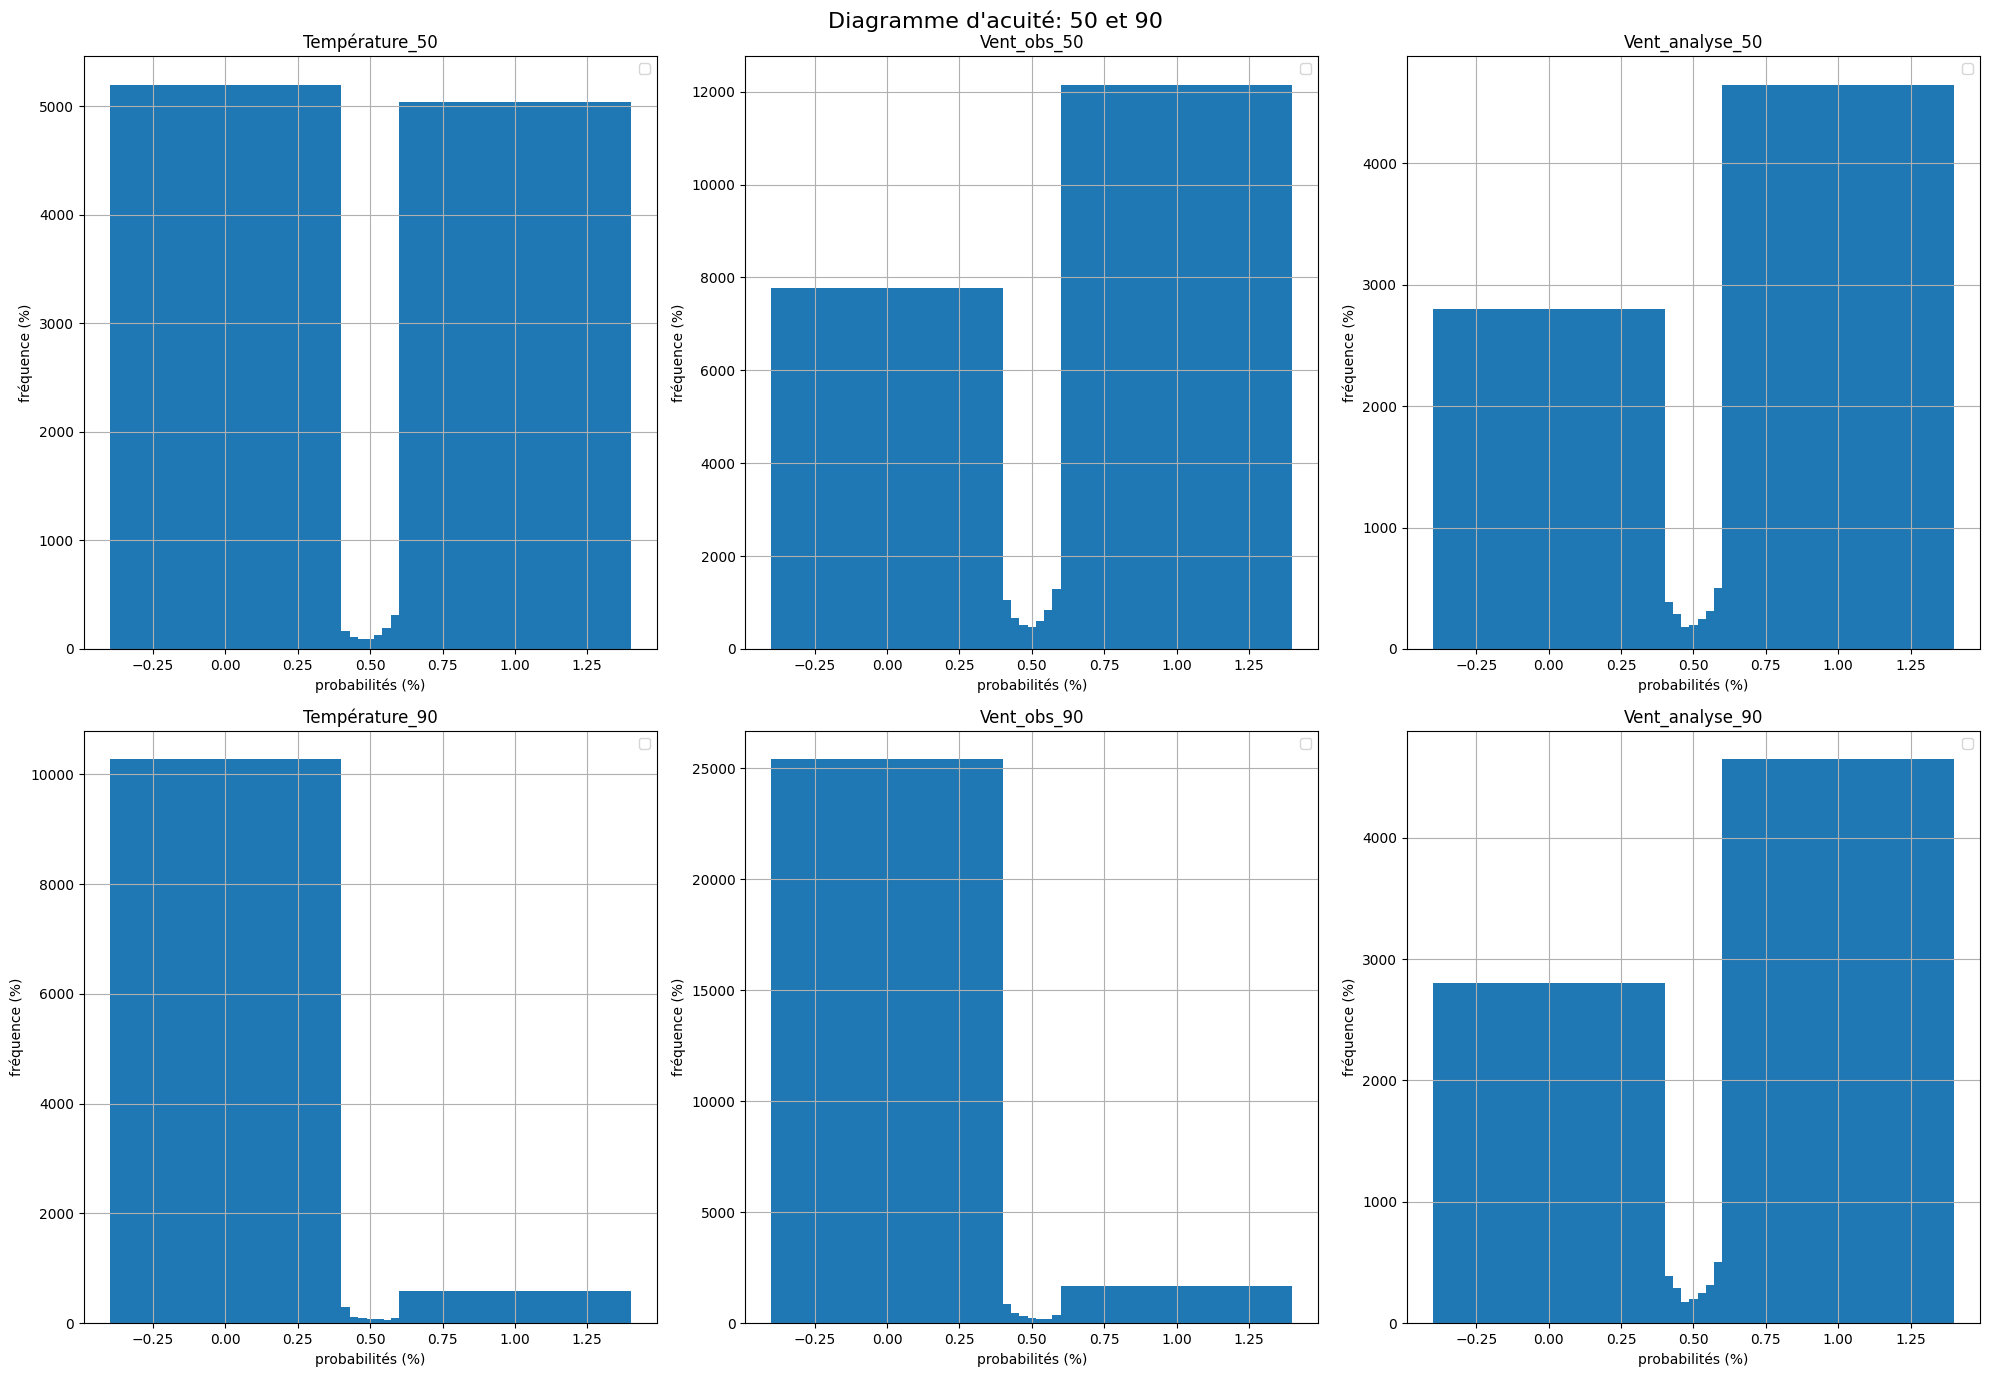

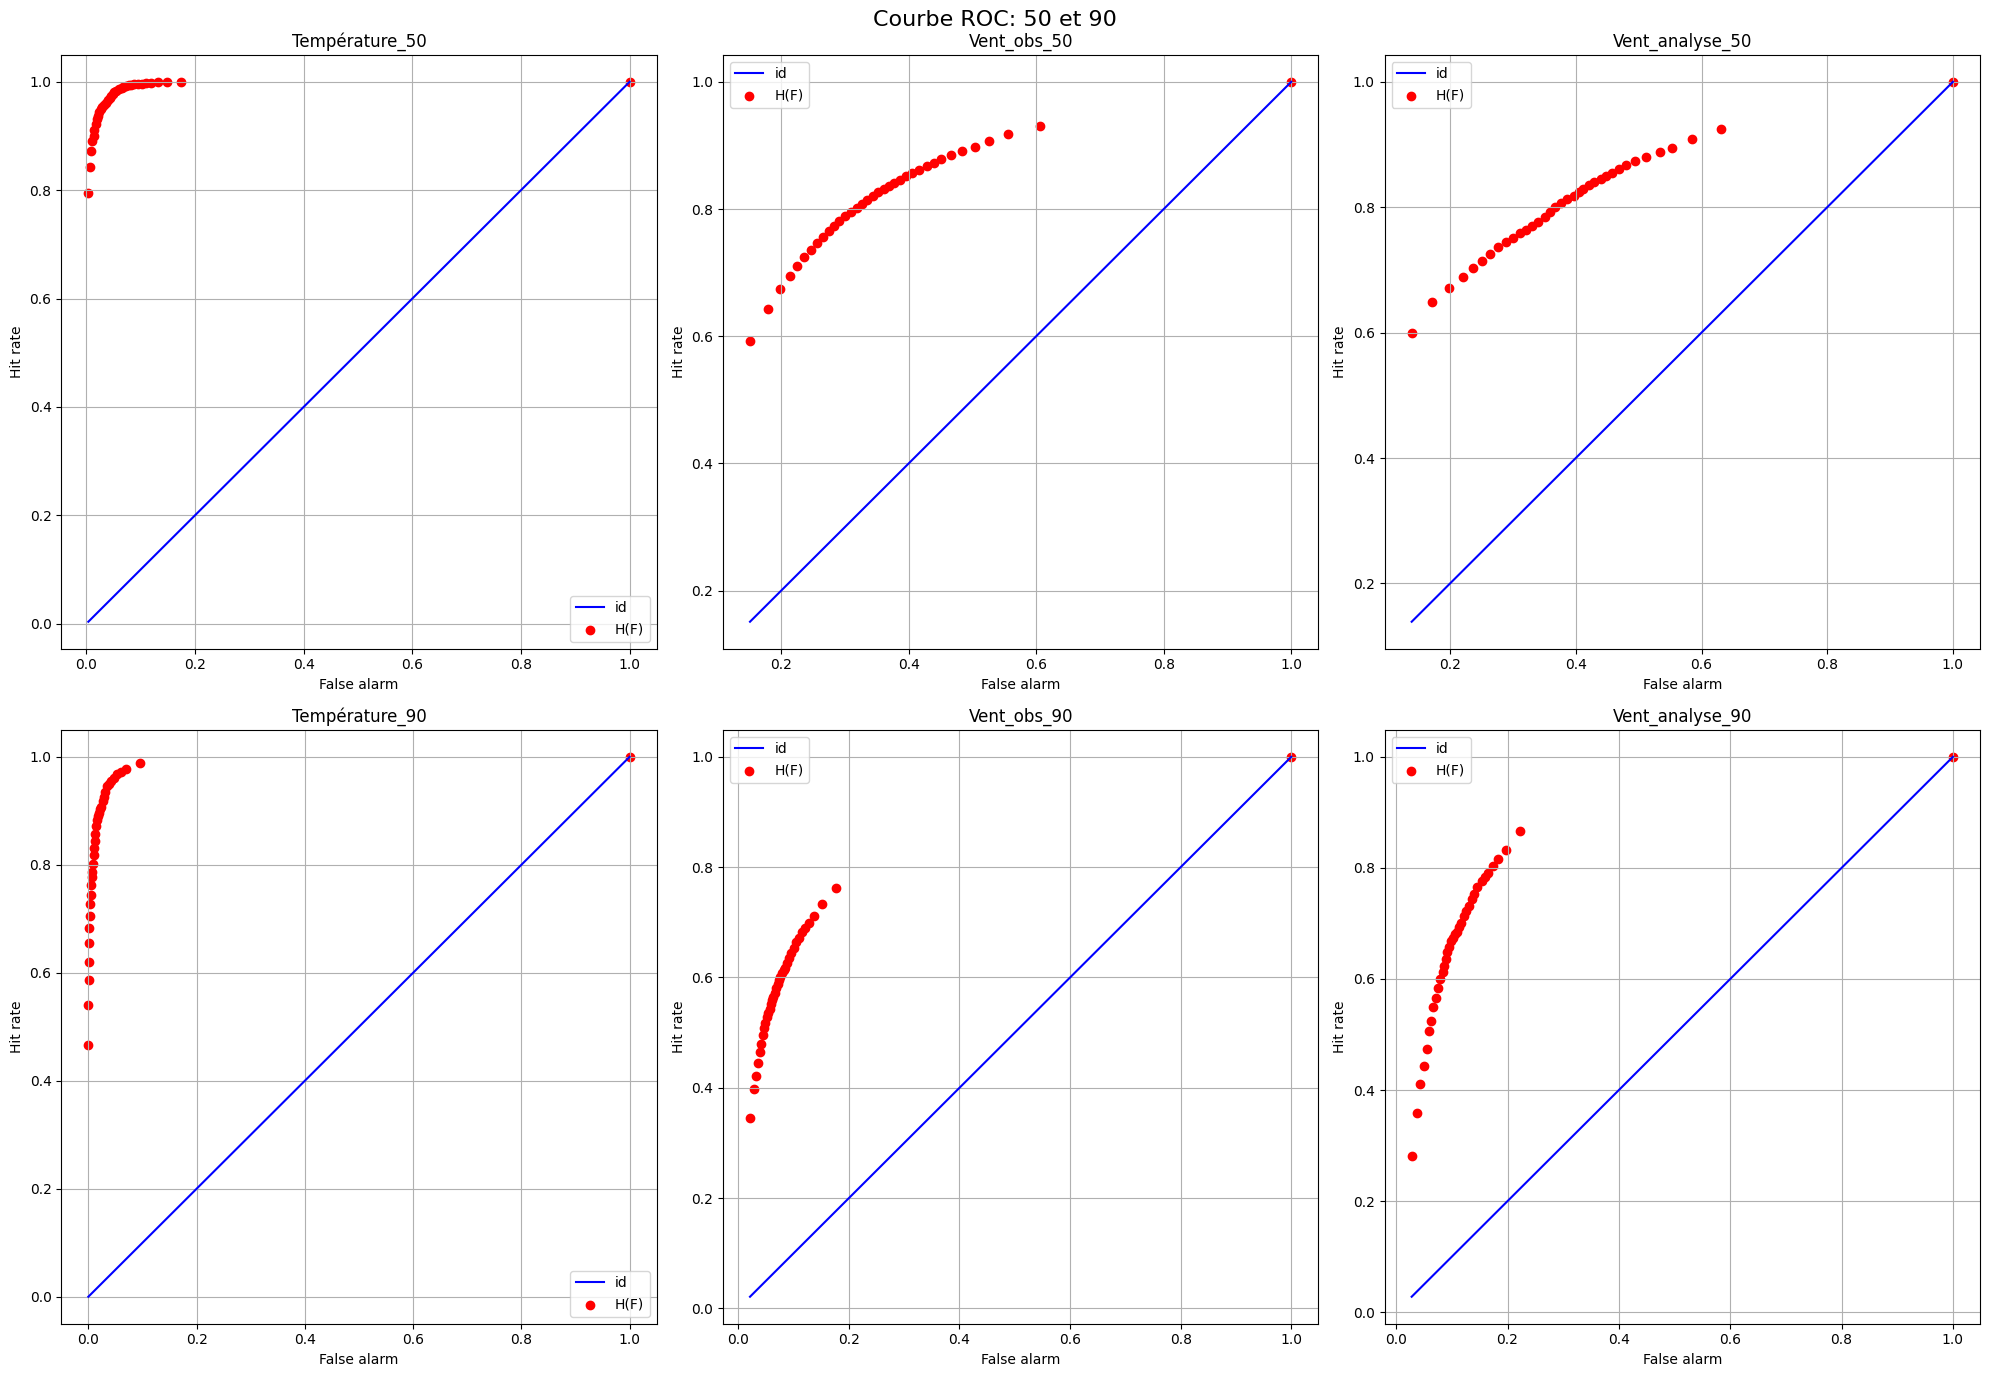

In [87]:
graphsExec(Fiab, Acuite, ROC, dict_fiab, pc, dict_acuite, dict_ROC, [50, 90], 3)

#### Diagramme de Fiabilité

Dans ces graphiques nous pouvons tout d'abord voir que la probabilité climatologiques est fixe à 50%, ce qui est logique en vue du seuil qu'on a défini (à partir de la médiane).

D'une autre part le modèle est beaucoup plus fiable pour la température (gauche) que pour le vent (droite). Malgré le bruit présent dans les deux cas d'analyse, on voit que la température conserve une allure qui se rapproche plus de celle de l'identité. 

Cela est dû à plusiers choses: le vent est mesuré très ponctuellement alors que nos prévisions sont faites par des moyennes de valeurs dans un parallélepipède. Cela donne une incompatibilité de comparaison tant qu'on utilise des observations comme référence. D'une autre part le modèle a aussi plus de mal a être bon puisque la hauteur des mesures de cette unité (10m) n'est pas assez élévée comme pour que les interactions avec le sol soient négligées. 

#### Diagramme d'Acuité

Dans ce graphique on voit que l'incertitude est plutôt pas mal dans les deux cas: les probabilités le plus souvent prévues sont près de 0 et de 1. Néanmoins dans le cas du vent on trouve un flagrant désequilibre.

On pourrait conclure, se situant au graphique de droite du diagramme de fiabilité, qu'il y a un manque de dispersion dans les prévisions: en effet, dans le diagramme d'acuité on observe que les probabilités prévues en général, sont beaucoup trop élevées.

#### Courbe ROC

La courbe ROC nous indique les nombre de "high rates" en fonction des "false alarms". Cela veut dire qu'un modèle sera meilleur si on se trouve dans la partie haute du graphique.

Comme on pouvait espèrer, le rapport entre appels légitimes et fausses alarmes dans le cas de la temérature est beaucoup meilleur que dans le cas du vent, même si cela reste positif. 

## Au délà de la 1ère analyse

On remarque que quand on augmente le percentil, les résultats sont en général moins bons puisque c'est une condition beaucoup plus exigente.

On voit aussi que dans le cas du vent, la partie d'analyse est assez similaire à la partie d'observation, mais on remarque une difference dans le ratio de réussites dans le cas 90, avec un avantage dans l'analyse par rapport à l'observation.
Ces résultats ne sont pas satisfaisants pour considèrer une prévision d'ensemble pour l'intensité du vent. En effet, les cas de réussite de diagnostic ne sont pas suffisament fréquents. C'est pour cela que nous allons traîter une prévision deterministe et on va comparer le résultat avec ceux de la prévision d'ensemble dans la courbe ROC.

De plus, il serait intéressant, dans chaque cas, de voir quel est le point de la courbe ROC qui se rapproche le plus de notre "point idéal" (0,1), nous permettant de voir quel est le seuil de probabilité le plus utile. 
Nous allons donc définir une fonction qui nous permet de le voir et après, nous allons traîter la partie deterministe.

### Seuil de probabilité idèal

In [88]:
# Catégorie de probabilité optimale
def pointROC (dictionnaire, k):
    titres = list(dictionnaire.keys())
    matrices = list(dictionnaire.values())
    pCats = np.arange(k+1)/k

    print("Les catégories de probabilité optimale sont:\n")
    for i, mat in enumerate(matrices):
        dist = np.sqrt((mat[:,0])**2 + (mat[:,1] - 1)**2)
        for idx in pCats:
            idx = np.argmin(dist)
        
        print(f"{titres[i]}:\n", pCats[idx])    

    return

Cette fonction va nous donner la probabilité à établir dans le seuil pour laquelle on a le meilleur rapport high rate / false alarm: 

In [89]:
# Catégorie de probabilité optimale.
pointROC(dict_ROC, kT)

Les catégories de probabilité optimale sont:

Température_50:
 0.5882352941176471
Température_90:
 0.17647058823529413
Vent_obs_50:
 0.8235294117647058
Vent_obs_90:
 0.029411764705882353
Vent_analyse_50:
 0.8823529411764706
Vent_analyse_90:
 0.058823529411764705


### Cas detérministe

Quand on utilise la médiane comme seuil, la prédiction deterministe est un peu prés dans la tas de l'ensemble, mais quand on établit un percentil de 90%, on voit que la prévision deterministe a du mal a se declancher: cela veut dire que y a un biais sur les données qui empêche les prévisions de monter jusqu'à notre seuil de declanchement.

On a fait cette même courbe en prennant des différentes colonnes en tant que prévision deterministe et le résultat a été identique. C'est ici qu'on voit que toutes les prévisions deterministes sont de la même qualité et que force de la prévision d'ensemble est bien donnée par l'ensemble et pas par la prévision.

## 2ème analyse: prise en compte des erreurs d'observation

Jusqu'à maintenant nous avons réalisé une analyse ststistique des données par rapport à des observations et analyses en définissant des événements pour les percentiles 50% et 90%. Maintenant, on va réaliser la même analyse, mais cette fois ci, en prennant en compte les erreurs de représentativité.

L'idée pour la suite est de prendre en compte les erreurs d'observation au moment de faire la prévision. Nous allons faire cela de deux façons différentes: en perturbant les observations et avec les 'conditional predictands', qui assurent un comportement non biaisé et propre.

Nous allons tout d'abord faire cetta analyse avec les données du vent.La distribution d'erreur de base est établie comme une normale tronquée de laquelle on va estimer les paramètres.

On va d'abord voir comment les perturbations agissent et après on réalusera la même analyse statistique en la superpposant avec nos résultats antérieurs (dans le cas du vent seulement).


### Fonctions pour l'analyse du vent

Tout d'abord nous avons une fonction basée sur l'artcle suivi qui décrit les paramètres de la loi qu'on va suivre pour choisir nos perturbations

In [90]:
def param_vent (maille, y):
    # Ici delta c'est le pas du maillage
    moy_y = y.sum()/(len(y))
    alpha0 = -0.02*maille
    alpha1 = 1 + 0.002*maille
    beta1 = -0.04*maille + 0.17*maille**(0.75)

    mu = alpha0 + alpha1*moy_y
    sigma_repre = beta1 * np.sqrt(moy_y) + epsilon

    return mu, sigma_repre

On a aussi besoin d'une fonction qui va choisir les perturbations et les appliquer (sans changer la moyenne de notre distribution de base).

In [108]:
def conv_vent (y, nVal, obs, maille):
    y = y.copy()
    mu, sigma_repre = param_vent(maille, y)

    sigma_mesure = np.maximum(0.2, 0.05*obs)
    sigma = np.sqrt(sigma_mesure**2 + sigma_repre**2)

    # Paramètres pour la cut-off à 0
    a1 = (0 - mu) / sigma_repre
    a2 = (0 - mu) / sigma
    b = np.inf

    # Distribution de l'erreur 
    dist1 = truncnorm(a1, b, loc=mu, scale=sigma_repre)
    dist2 = truncnorm(a2, b, loc=mu, scale=sigma)
    samples = dist2.rvs(size=nVal) # Prend nVal valeurs aléatoires suivant dist
    moy_samples = np.mean(samples)
    var_samples = np.var(samples)
    y += samples - moy_samples

    # return y, var_samples
    return y

Et une fonction qui va nous permettre de récupérer les sigmas des perturbations afin de pouvoir en avoir un contrôle.

In [92]:
def sigmaMean (bd, obs, delta):
    beta = -0.04*delta + 0.17*delta**(0.75)
    moy_y = bd.mean(axis=1)
    sigma_repre = beta * np.sqrt(moy_y) + epsilon
    sigma_mesure = np.maximum(0.2, 0.05 * obs)
    sigma_mean = np.sqrt(sigma_mesure**2 + sigma_repre**2).mean()

    return sigma_mean

Et, pour finir, une fonction qui va venir comparer les valeurs de RMSE et la variance. On va l'utiliser avec nos données avant et après la perturbation. Cela est un marqueur de la justesse de notre prévision puisque ces valeurs devraient être proches.

In [93]:
def RMSEcheck (prev, obs):
    prev_mean = prev.mean(axis=1)
    rmse = np.sqrt(np.mean((prev_mean - obs)**2))
    var = np.sqrt(np.mean(prev.var(axis=1)))
    return rmse, var

### L'analyse du vent pertubée


#### Main de cette 2ème partie

On envoie nos données à nos fonctions et on applique un contrôle pour voir l'effet de la perturbation sur la moyenne et sur la variance de nos groupes.

On commence par établir les données perturbées et applatir les données non perturbées.

In [ ]:
# Analyse des perturbations
###########################

avant_1DV_1l = prevV[0,:].ravel()
apres_1DV_1l = conv_vent(prevV[0,:], kV, obsV[0], delta) 
"On fait ça pour controler ligne par ligne aussi (on regarde ce qu'il se passe sur la 1ere)"
avant_1DV = prevV.ravel()
apres_1DV = np.array([
    conv_vent(prevV[i, :], kV, obsV[i], delta)
    for i in range(prevV.shape[0])
]).ravel()
avant_1DVa = prevVa.ravel()
apres_1DVa = np.array([
    conv_vent(prevVa[i, :], kVa, obsVa[i], delta)
    for i in range(prevVa.shape[0])
]).ravel()


In [95]:
# Variables de contrôle
mediaV_1l_av = np.mean(avant_1DV_1l)
varV_1l_av = np.var(avant_1DV_1l)

mediaV_av = np.mean(avant_1DV)
varV_av = np.var(avant_1DV)

mediaVa_av = np.mean(avant_1DVa)
varVa_av = np.var(avant_1DVa)

mediaV_1l_ap = np.mean(apres_1DV_1l)
varV_1l_ap = np.var(apres_1DV_1l)

mediaV_ap = np.mean(apres_1DV)
varV_ap = np.var(apres_1DV)

mediaVa_ap = np.mean(apres_1DVa)
varVa_ap = np.var(apres_1DVa)

print("Moyenne 1l vent obs avant/après:", mediaV_1l_av, mediaV_1l_ap)
print("Moyenne vent obs avant/après:", mediaV_av, mediaV_ap)
print("Moyenne vent ana avant/après:", mediaVa_av, mediaVa_ap)

print("Variance 1l vent obs avant/après:", varV_1l_av, varV_1l_ap)
print("Variance vent obs avant/après:", varV_av, varV_ap)
print("Variance vent ana avant/après:", varVa_av, varVa_ap)

Moyenne 1l vent obs avant/après: 14.091999999999999 14.091999999999999
Moyenne vent obs avant/après: 4.297573379959418 4.297573379959418
Moyenne vent ana avant/après: 4.474160770975057 4.474160770975057
Variance 1l vent obs avant/après: 0.9236045714285712 4.770848485995043
Variance vent obs avant/après: 10.13289281297872 11.064476402454728
Variance vent ana avant/après: 10.635445949662897 11.609754918656536


On voit bien que dans les deux cas la moyenne reste invariante et la variance augmente, ce qui montre que notre procedure est correcte.

D'une autre part on contrôle la variance des perturbations utilisées:

In [96]:
sigma_meanV = sigmaMean(prevV, obsV, delta)
sigma_meanVa = sigmaMean(prevVa, obsVa, delta)

print("La variances des perturbations pour vent obs est:", sigma_meanV)
print("La variances des perturbations pour vent ana est:", sigma_meanVa)

La variances des perturbations pour vent obs est: 0.9300093885561108
La variances des perturbations pour vent ana est: 0.946839745684729


#### Distribution des données perturbées

Dans le main, on a applati nos données pour pouvoir faire un graphique controlateur de la distribution qu'elles suivent. On crée le dictionnaire correspondant et on envoie ça a la fonction qui va nous dessiner la pdf et la cdf:

In [97]:
def graphic_pdf_cdf (dictionnaire, nPer, nVar, titre, titre_variable, xlabel, ylabel, CDF):

    nFig, axs = plt.subplots(nPer, nVar)
    axs = np.atleast_2d(axs)

    nFig.suptitle(titre, fontsize=16)
    titres = list(dictionnaire.keys())
    series = list(dictionnaire.values())

    for i, ser in enumerate(series):
        if nPer == 1:
            row = 0
            col = i
        else:
            row = (i) % nPer
            col = int(i/nPer)
    
        if CDF==True:
            n = len(ser)
            valeurs_cdf = np.sort(ser)
            cdf = np.arange(1, n+1) / n
            axs[row, col].plot(valeurs_cdf, cdf, label=titre_variable, color='red')

        else:
            axs[row,col].hist(ser,
                bins=50,
                density=True,
                alpha=0.7,
                color='red',
                label=titre_variable
            )
        axs[row,col].set_title(titres[i])
        axs[row,col].set_xlabel(xlabel)
        axs[row,col].set_ylabel(ylabel)
        axs[row,col].legend() 
        axs[row,col].grid(True)

    plt.tight_layout()
    plt.show()


Et donc, dans le main:

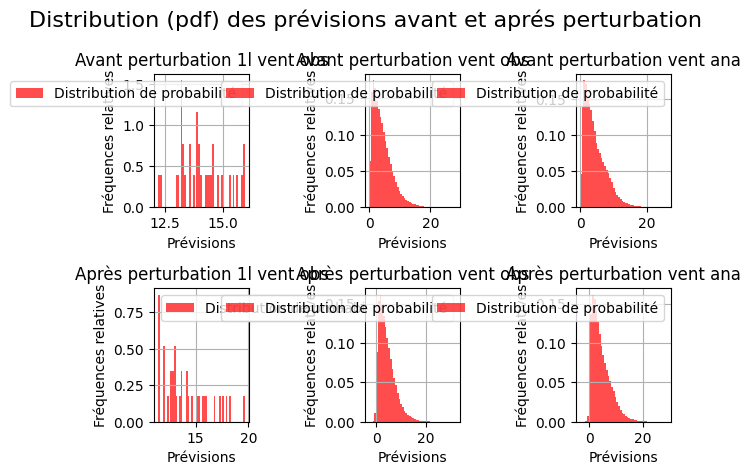

/var/folders/xf/srzrz9sd5xgb879vnxs7l8sm0000gn/T/ipykernel_17919/1876474431.py:38: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


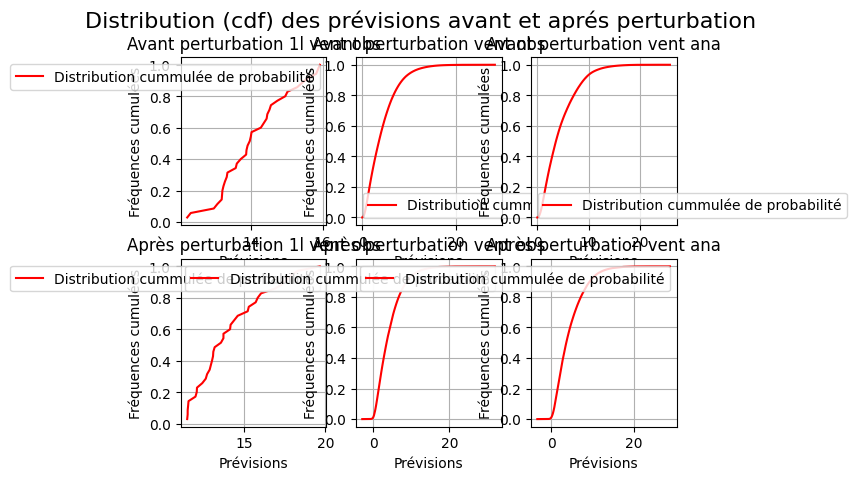

In [98]:
dict_all = {
    "Avant perturbation 1l vent obs": avant_1DV_1l, 
    "Après perturbation 1l vent obs": apres_1DV_1l,
    "Avant perturbation vent obs": avant_1DV, 
    "Après perturbation vent obs": apres_1DV,
    "Avant perturbation vent ana": avant_1DVa, 
    "Après perturbation vent ana": apres_1DVa
}

titre = "Distribution (pdf) des prévisions avant et aprés perturbation"
titre_variable = "Distribution de probabilité"
xlabel = "Prévisions"
ylabel = "Fréquences relatives"

graphic_pdf_cdf(dict_all, 2, 3, titre, titre_variable, xlabel, ylabel, CDF=False)

titre = "Distribution (cdf) des prévisions avant et aprés perturbation"
titre_variable = "Distribution cummulée de probabilité"
xlabel = "Prévisions"
ylabel = "Fréquences cumulées"

graphic_pdf_cdf(dict_all, 2, 3, titre, titre_variable, xlabel, ylabel, CDF=True)

C'est normal que dans le cas de vent obs les dessins soient bizarres puisqu'on a juste fair l'analyse sur la première ligne.

#### Comparaison des diagrammes de base (Fiabilité, Acuité, ROC)

On remet les données en place et on réalise les mêmes procédures qu'avec les autres afin de pouvoir comparer la précision de nos prévisions avant et après les perturbations.

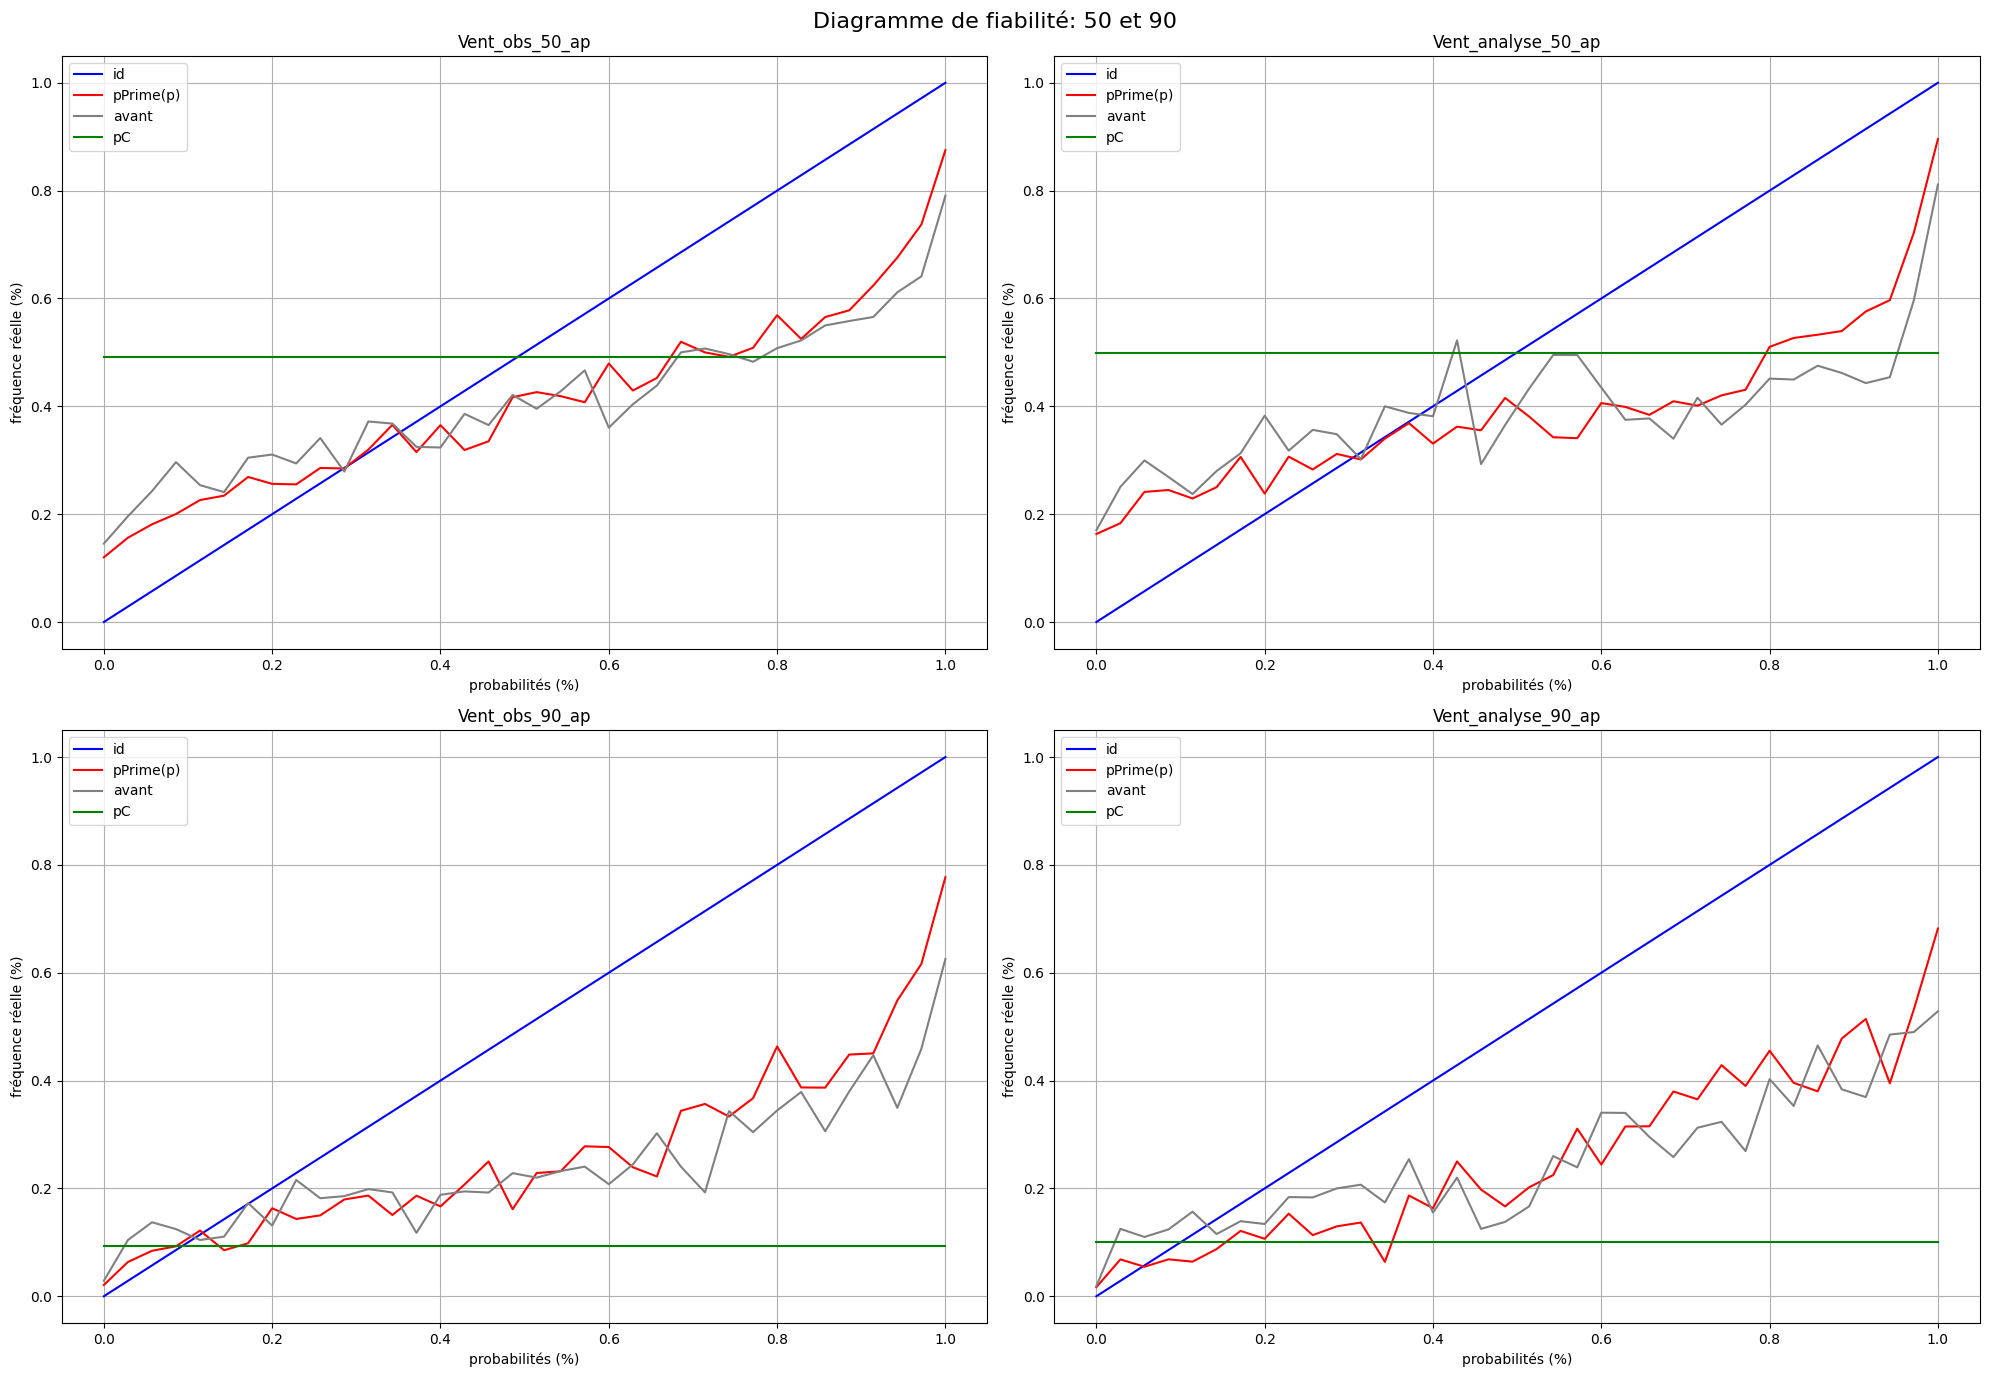

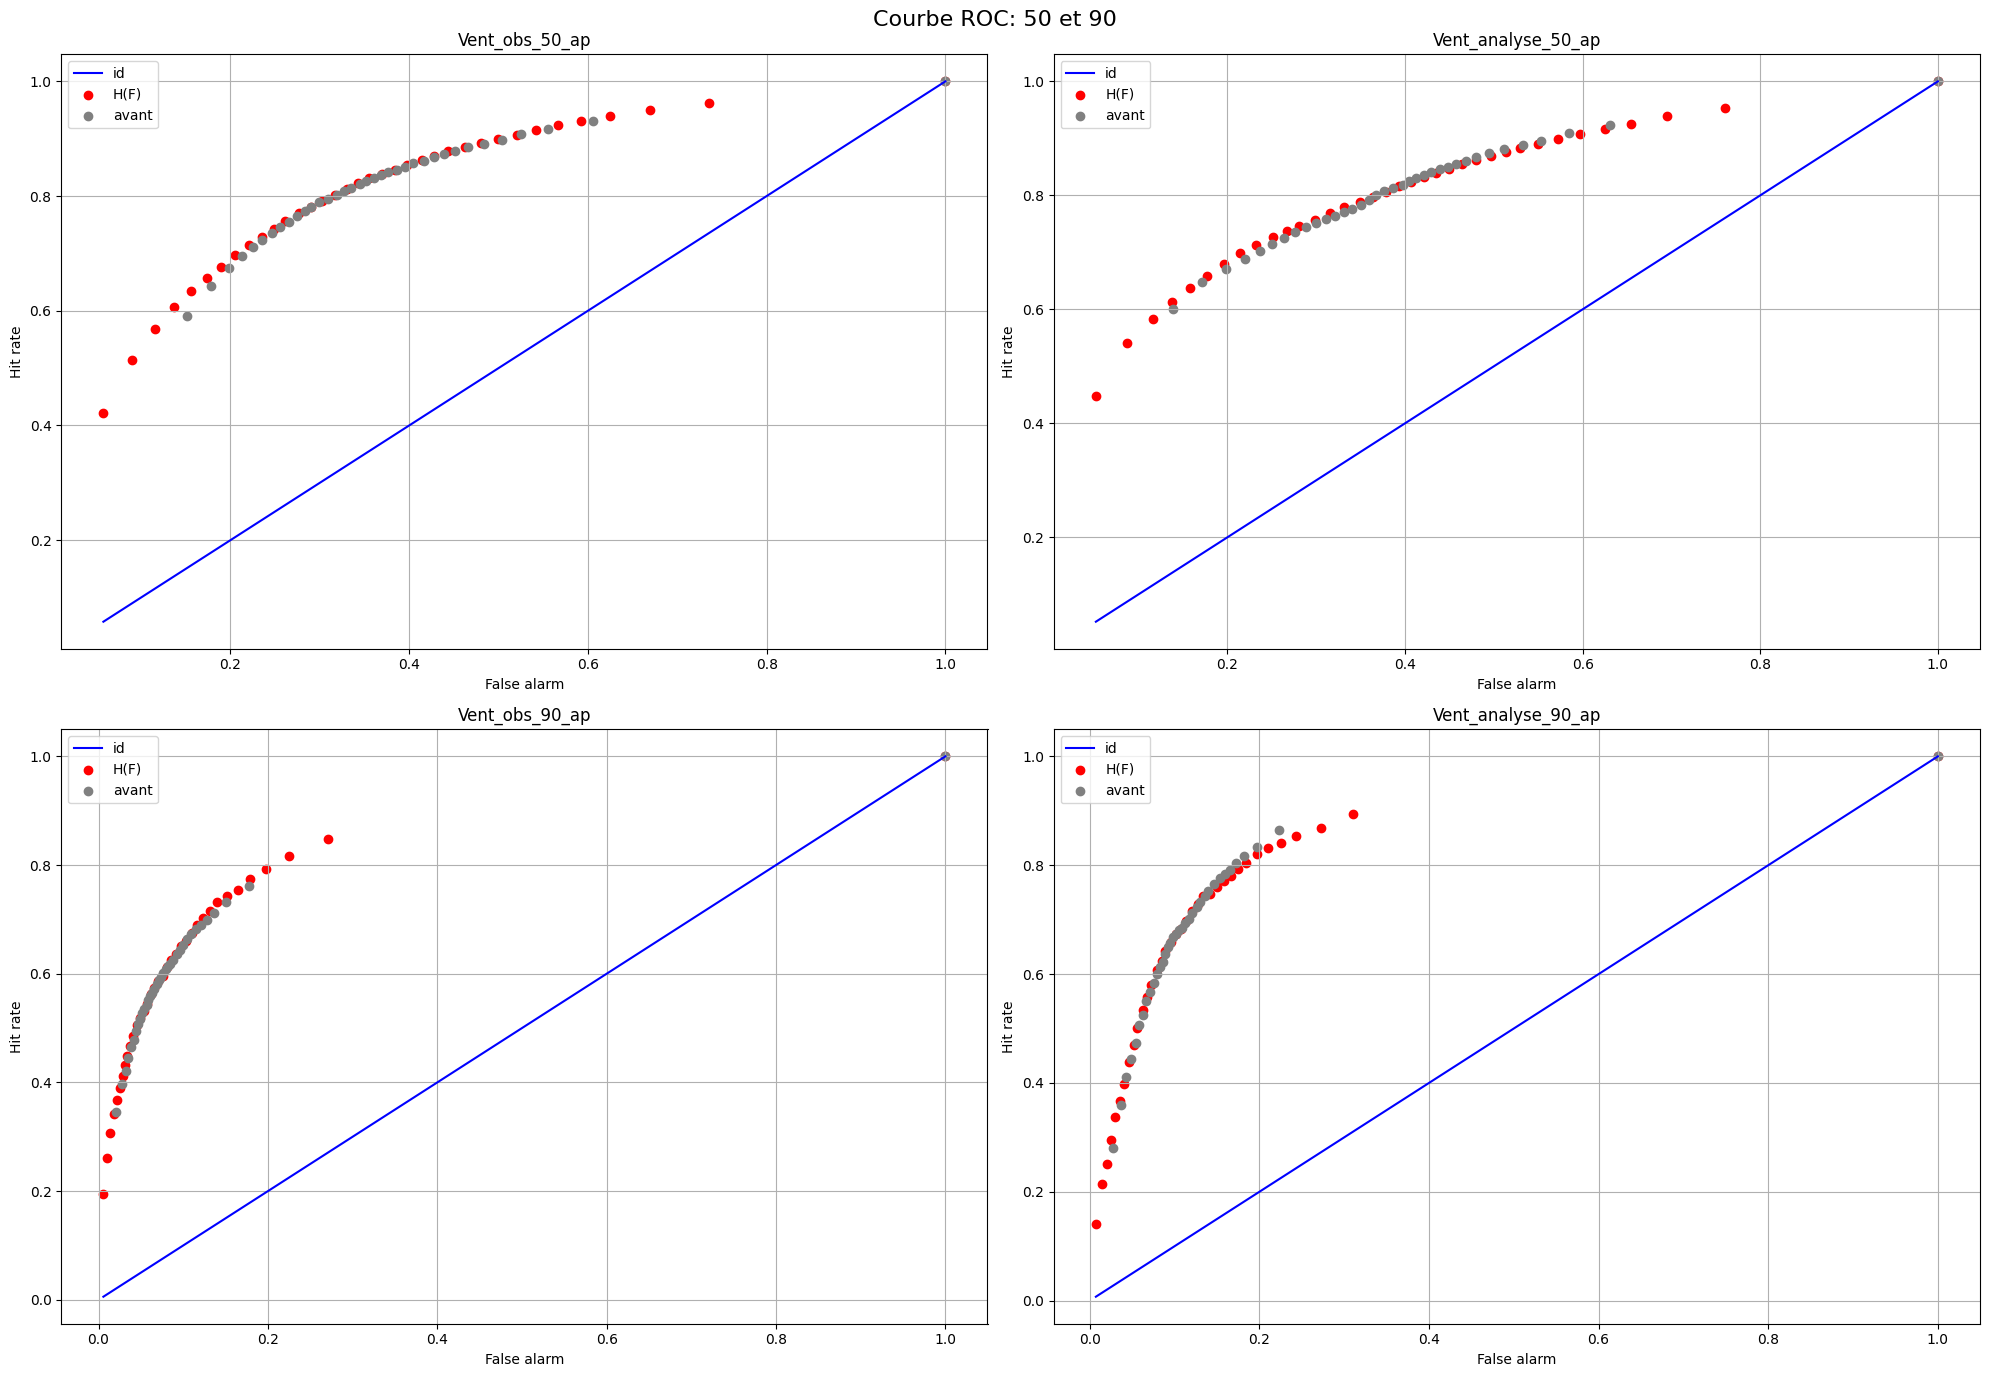

In [99]:
# Analyse avec les nouvelles valeurs
####################################

prevV_ap = apres_1DV.reshape(-1, kV)
prevVa_ap = apres_1DVa.reshape(-1, kVa)

condV50_ap, EtheoV50_ap, EobsV50_ap, NpV50_ap, pPrimeV50_ap, pcV50_ap, HV50_ap, FV50_ap = mainExec(obsV, prevV_ap, kV, NV, 50)
condV90_ap, EtheoV90_ap, EobsV90_ap, NpV90_ap, pPrimeV90_ap, pcV90_ap, HV90_ap, FV90_ap = mainExec(obsV, prevV_ap, kV, NV, 90)

condVa50_ap, EtheoVa50_ap, EobsVa50_ap, NpVa50_ap, pPrimeVa50_ap, pcVa50_ap, HVa50_ap, FVa50_ap = mainExec(obsVa, prevVa_ap, kV, NV, 50)
condVa90_ap, EtheoVa90_ap, EobsVa90_ap, NpVa90_ap, pPrimeVa90_ap, pcVa90_ap, HVa90_ap, FVa90_ap = mainExec(obsVa, prevVa_ap, kV, NV, 90)

# Diagramme de fiabilité
########################
pc_ap = [pcV50_ap, pcV90_ap, pcVa50_ap, pcVa90_ap]

two_pPrimeV50 = np.hstack((pPrimeV50_ap, pPrimeV50))
two_pPrimeV90 = np.hstack((pPrimeV90_ap, pPrimeV90))
two_pPrimeVa50 = np.hstack((pPrimeVa50_ap, pPrimeVa50))
two_pPrimeVa90 = np.hstack((pPrimeVa90_ap, pPrimeVa90))

dict_fiab_ap = {"Vent_obs_50_ap": two_pPrimeV50, "Vent_obs_90_ap": two_pPrimeV90,
                "Vent_analyse_50_ap": two_pPrimeVa50, "Vent_analyse_90_ap": two_pPrimeVa90
                }

# Diagramme d'acuité
####################

dict_acuite_ap = {"Vent_obs_50_ap": NpV50_ap, "Vent_obs_90_ap": NpV90_ap,
            "Vent_analyse_50_ap": NpVa50_ap, "Vent_analyse_90_ap": NpVa50_ap}

# Courbe de ROC
###############

FHV50_ap = np.vstack((FV50_ap, HV50_ap)).T
FHV90_ap = np.vstack((FV90_ap, HV90_ap)).T
FHVa50_ap = np.vstack((FVa50_ap, HVa50_ap)).T
FHVa90_ap = np.vstack((FVa90_ap, HVa90_ap)).T

two_FHV50 = np.hstack((FHV50_ap, FHV50))
two_FHV90 = np.hstack((FHV90_ap, FHV90))
two_FHVa50 = np.hstack((FHVa50_ap, FHVa50))
two_FHVa90 = np.hstack((FHVa90_ap, FHVa90))

dict_ROC_ap = {"Vent_obs_50_ap": two_FHV50, "Vent_obs_90_ap": two_FHV90,
            "Vent_analyse_50_ap": two_FHVa50, "Vent_analyse_90_ap": two_FHVa90}

Acuite=False
graphsExec(Fiab, Acuite, ROC, dict_fiab_ap, pc_ap, dict_acuite_ap, dict_ROC_ap, [50, 90], 2)


On voit dans ces graphiques une legère amélioration de la prévision perturbée par rapport à la prévision de base. 

#### RMSE vs. variance

In [126]:
# RMSE VS. ÉCART-TYPE
#####################

rmseV_av = []
rmseV_ap = []
ectV_av = []
ectV_ap = []

rmseVa_av = []
rmseVa_ap = []
ectVa_av = []
ectVa_ap = []

rmseV_av.append(RMSEcheck(prevV, obsV)[0])
ectV_av.append(RMSEcheck(prevV, obsV)[1])

rmseV_ap.append(RMSEcheck(prevV_ap, obsV)[0])
ectV_ap.append(RMSEcheck(prevV_ap, obsV)[1])

rmseVa_av.append(RMSEcheck(prevVa, obsVa)[0])
ectVa_av.append(RMSEcheck(prevVa, obsVa)[1])

rmseVa_ap.append(RMSEcheck(prevVa_ap, obsVa)[0])
ectVa_ap.append(RMSEcheck(prevVa_ap, obsVa)[1])


# rmseV_av, ectV_lignes_av = RMSEcheck(prevV, obsV)
# rmseV_ap, ectV_lignes_ap = RMSEcheck(prevV_ap, obsV)

# rmseVa_av, ectVa_lignes_av = RMSEcheck(prevVa, obsVa)
# rmseVa_ap, ectVa_lignes_ap = RMSEcheck(prevVa_ap, obsVa)

print("Vent obs avant: RMSE, écart type", rmseV_av, ectV_av)
print("Vent obs apres: RMSE, écart type", rmseV_ap, ectV_ap)

print("Vent ana avant: RMSE, écart type", rmseVa_av, ectVa_av)
print("Vent ana apres: RMSE, écart type", rmseVa_ap, ectVa_ap)

Vent obs avant: RMSE, écart type [np.float64(2.486895791752967)] [np.float64(0.862054995635481)]
Vent obs apres: RMSE, écart type [np.float64(2.486895791752967)] [np.float64(1.294110661796779)]
Vent ana avant: RMSE, écart type [np.float64(2.433348784385893)] [np.float64(0.9718693815982892)]
Vent ana apres: RMSE, écart type [np.float64(2.433348784385893)] [np.float64(1.3852216659733125)]


De nouveau, on voit l'évidence de l'amélioration avec la pertubation des données. En effet, elle fait que la variance augment, et vu que le RMSE était supérieur avec un facteur approximatif x2.88, ce facteur s'est vu réduit à x1.9 dans le cas du vent_obs. 

### Variation de la maille

Il serait intéressant de voir maintenant comment varient les données statistiques en fonction des changements de maille. Jusqu'à maintenant nous avons assumé delta = 7km. Maintenant, on va faire les calculs pour 10, 15 et 20km afin de constater la dépendence de nos résultats sur cette distance.

In [105]:
# Ordres de grandeur de la maille
delta10 = 10
delta15 = 15
delta20 = 20

In [106]:
# Calcul des sigmas correspondents
##################################

# sigma = 10

sigma_meanV10 = sigmaMean(prevV, obsV, delta10)
sigma_meanVa10 = sigmaMean(prevVa, obsVa, delta10)

print("\nLa variances des perturbations pour vent obs et delta = 10 est:", sigma_meanV10)
print("La variances des perturbations pour vent ana et delta = 10 est:", sigma_meanVa10)

# sigma = 15

sigma_meanV15 = sigmaMean(prevV, obsV, delta15)
sigma_meanVa15 = sigmaMean(prevVa, obsVa, delta15)

print("La variances des perturbations pour vent obs et delta = 15 est:", sigma_meanV15)
print("La variances des perturbations pour vent ana et delta = 15 est:", sigma_meanVa15)

# sigma = 20

sigma_meanV20 = sigmaMean(prevV, obsV, delta20)
sigma_meanVa20 = sigmaMean(prevVa, obsVa, delta20)

print("\nLa variances des perturbations pour vent obs et delta = 20 est:", sigma_meanV20)
print("La variances des perturbations pour vent ana et delta = 20 est:", sigma_meanVa20)


La variances des perturbations pour vent obs et delta = 10 est: 1.1262788669390764
La variances des perturbations pour vent ana et delta = 10 est: 1.1478448881394852
La variances des perturbations pour vent obs et delta = 15 est: 1.3921642132647278
La variances des perturbations pour vent ana et delta = 15 est: 1.4199661915814483

La variances des perturbations pour vent obs et delta = 20 est: 1.606788420372827
La variances des perturbations pour vent ana et delta = 20 est: 1.6395287070257647


On veut voir maintenant comment le rapport RMSE/ect varie en fonction de la taille de la maille. La taille suposée est delta = 7km. Mais il s'agit seulement de la valeur théorique. En effet, à cause d'une interpolation au moment d'une transition entre un espace continu et un espace discret, la représentativité réelle peut être beaucoup plus élévée. C'est pour ça que, dans le doute de pas avoir la bonne taille, on va regarder comment ce score varie en fonction de notre possible erreur. 

Pour réaliser cette analyse nous allons seulement utiliser les valeurs de vent obs.

In [117]:
# RMSE vs. écart-type (variation maille)
########################################

# delta = 10

apres10_1DV = np.array([
    conv_vent(prevV[i, :], kV, obsV[i], delta10)
    for i in range(prevV.shape[0])
]).ravel()

# delta = 15

apres15_1DV = np.array([
    conv_vent(prevV[i, :], kV, obsV[i], delta15)
    for i in range(prevV.shape[0])
]).ravel()

# delta = 20

apres20_1DV = np.array([
    conv_vent(prevV[i, :], kV, obsV[i], delta20)
    for i in range(prevV.shape[0])
]).ravel()

In [127]:
# delta = 10
prevV10_ap = apres10_1DV.reshape(-1, kV)
rmseV_ap.append(RMSEcheck(prevV10_ap, obsV)[0])
ectV_ap.append(RMSEcheck(prevV10_ap, obsV)[1])

# delta = 15
prevV15_ap = apres15_1DV.reshape(-1, kV)
rmseV_ap.append(RMSEcheck(prevV15_ap, obsV)[0])
ectV_ap.append(RMSEcheck(prevV15_ap, obsV)[1])

# delta = 20
prevV20_ap = apres20_1DV.reshape(-1, kV)
rmseV_ap.append(RMSEcheck(prevV20_ap, obsV)[0])
ectV_ap.append(RMSEcheck(prevV20_ap, obsV)[1])

In [128]:
# Rapport des deux vecteurs
rmseV_ap = np.array(rmseV_ap)
ectV_ap = np.array(ectV_ap)
rapportV_ap = rmseV_ap/ectV_ap

Maintenant pour tracer notre graphique nous avons besoin de deux choses:
1. Un vecteur qui regroupe toutes les valeurs maillage qu l'on a utilisé.
2. Une fonction qui nous trace le graphique.

In [132]:
# Vecteur
delta_vector = [delta, delta10, delta15, delta20]

In [130]:
# Fonction

def graph_simple(x, y, titre_variable, xlabel, ylabel):
    plt.figure()
    plt.plot(x, y, '-', color='blue')
    plt.plot(x, y, 'x', color='black')

    plt.title(titre_variable)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

    plt.show()


/var/folders/xf/srzrz9sd5xgb879vnxs7l8sm0000gn/T/ipykernel_17919/3915746265.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


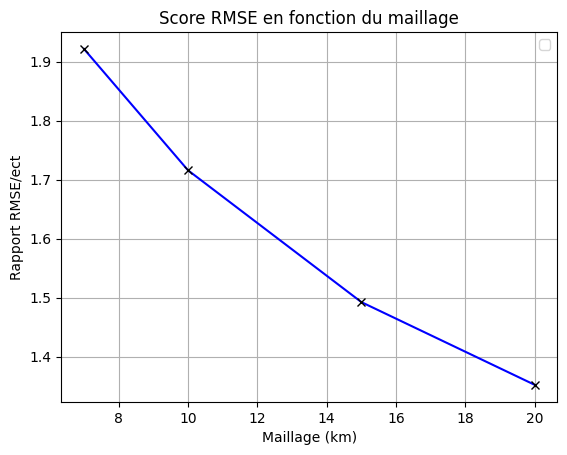

In [131]:
titre_variable = "Score RMSE en fonction du maillage"
xlabel = "Maillage (km)"
ylabel = "Rapport RMSE/ect"
graph_simple(delta_vector, rapportV_ap, titre_variable, xlabel, ylabel)

On voit clairement que nos résultats sont très fragiles au choix du maillage, donc on peut pas se permettre de se tromper.